In [0]:
#Data Processing package
import  pandas as pd
import numpy as np
import re

#Visiualization package
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#language Processing package
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
import tokenize
from nltk.stem.snowball import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#feature extraction package
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#ML algorithm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import itertools


In [0]:
df = pd.read_csv("./lyrics.csv")
print(df.shape)

df = df.dropna(subset=['lyrics'])
df=df[df.lyrics!=""]
df=df[df.genre!=""]
print(df.shape)


#編碼
df.genre.str.decode('utf-8')
df.lyrics.str.decode('utf-8')


#光哥line26
df.lyrics=df.lyrics.str.strip().str.lower()
df.genre=df.genre.str.strip().str.lower()


#光哥line38
df.lyrics.replace("\n", " ", regex=True, inplace=True)
df.lyrics.replace("-", " ", regex=True, inplace=True)
df.lyrics.replace("[^a-zA-Z0-9_\ ]", "", regex=True, inplace=True)
df.lyrics.replace('"', "", regex=True, inplace=True)

df.genre.replace("\n", " ", regex=True, inplace=True)
df.genre.replace("-", " ", regex=True, inplace=True)
df.genre.replace("[^a-zA-Z0-9_\ ]", "", regex=True, inplace=True)
df.genre.replace('"', "", regex=True, inplace=True)

(362237, 6)
(266557, 6)


In [0]:
#光哥line70
genre_list=list(set(df.genre))
year_list=list(set(df.year))
print(genre_list)
print(year_list)
print(df.genre.value_counts())
df.shape

['rb', 'rock', 'not available', 'electronic', 'metal', 'indie', 'country', 'other', 'pop', 'jazz', 'folk', 'hip hop']
[1988, 67, 1968, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 702, 1986, 1987, 1985, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 112]
rock             109235
pop               40466
hip hop           24850
not available     23941
metal             23759
country           14387
jazz               7971
electronic         7966
other              5189
rb                 3401
indie              3149
folk               2243
Name: genre, dtype: int64


(266557, 6)

In [0]:
#drop row if the year is before 2008
df=df[df.year >= 2008]
gen=['rock','hip hop','metal','country']
df=df.filter(items=['genre','lyrics'],axis=1)
df=df[df.genre.isin(gen)]

In [0]:
# Compose the corpus
Xr = np.array(df.lyrics.loc[df['genre']=='rock'])
Xh = np.array(df.lyrics.loc[df['genre']=='hip hop'])
Xm = np.array(df.lyrics.loc[df['genre']=='metal'])
Xc = np.array(df.lyrics.loc[df['genre']=='country'])

Xw = np.concatenate((Xr,Xh,Xm,Xc))
# Xp = np.array(df_a.lyrics.loc[df_a['genre']=='pop'])
# Xw = np.concatenate((Xr,Xp,Xh,Xm,Xc))


# Create the label vectors
Yr = np.zeros(shape=Xr.shape)
Yh = np.ones(shape=Xh.shape)
Ym = np.full(Xm.shape, 2)
Yc = np.full(Xc.shape, 3)

Y = np.concatenate((Yr,Yh,Ym,Yc))
# Yc = np.full(Xp.shape, 4)
# Y = np.concatenate((Yr,Yp,Yh,Ym,Yc))
print(len(Xw))
print(len(Y))

54827
54827


In [0]:
def tokenizer(sentence):
    np.random.seed(1000)
    ret = RegexpTokenizer('[a-zA-Z0-9\']+')
    sw = set(stopwords.words('english'))
    ess = SnowballStemmer('english', ignore_stopwords=True)
    tokens = ret.tokenize(sentence)
    tokens =[WordNetLemmatizer().lemmatize(t,'v') for t in tokens]
    return [ess.stem(t) for t in tokens if t not in sw]

In [0]:
# Vectorize
def vectorize(array):
    tfidfv = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1, 2), norm='l2',stop_words='english',min_df=0.01)
    Xv = tfidfv.fit_transform(array)
    return Xv,tfidfv

In [0]:
def term_rank(Xv,tfidfv):
    terms = tfidfv.get_feature_names()

    # sum tfidf frequency of each term through documents
    sums = Xv.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    ranking = pd.DataFrame(data, columns=['term','rank'])
    ranking=ranking.sort_values('rank',ascending=False)
    term=ranking.iloc[0:10,:]
    plt.barh(term['term'], term['rank'],orientation='horizontal')
    plt.yticks(term['term'].sort_index())
    plt.show()
    return ranking

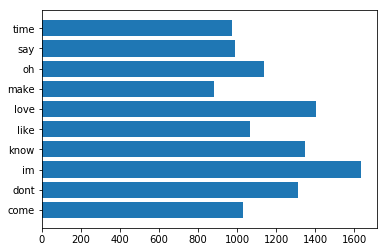

,term,rank
369,im,1632.400581
459,love,1401.800646
401,know,1347.584817
180,dont,1310.737881
521,oh,1137.795909
432,like,1066.044788
127,come,1031.079936
626,say,989.076128
786,time,972.860789
470,make,882.622251


In [0]:
term_rank(Xv,tfidfv)

In [0]:
#functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
# Prepare train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(Xv, Y, test_size=0.2)

In [0]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100,oob_score = True,verbose=1,max_features="auto",n_jobs=-1)

rf.fit(X_train, Y_train)

y_pred = rf.fit(X_train, Y_train).predict(X_test)
score = rf.score(X_test, Y_test)

cnf_matrix = confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='Random Forest')

In [0]:
# Create a Adaboost classifier
param_grid = {'n_estimators': list(range(1,100))}
ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100,learning_rate=0.1)
grid_ada = GridSearchCV(ad, param_grid, cv=10,verbose=10)
grid_ada.fit(X_train, Y_train)

print(grid_ada.best_estimator_)
y_pred = grid_ada.fit(X_train, Y_train).predict(X_test)
score = grid_ada.score(X_test, Y_test)
cnf_matrix = confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='AdaBoost')

In [0]:
%%time
#Create a XGBoost Classifier
data_train = xgb.DMatrix( trainX, label=trainY)
data_test  = xgb.DMatrix( testX, label=testY)


#給予模型參數，告知演算法該如何訓練模型
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
eval_list  = [(data_train,'train'),(data_test,'test')]
num_round = 50
eval_history={}

# 訓練模型
model = xgb.train( param, data_train, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)
rmse_train=eval_history['train']['rmse']
rmse_test=eval_history['test']['rmse']

plt.plot(rmse_train,ms=10,marker='.',label='train_eval')
plt.plot(rmse_test,ms=10,marker='v',label='test_eval')
plt.legend()
plt.show()

model.eval(data_test)

NameError: name 'DecisionTreeClassifier' is not defined

In [0]:
# Create a LogisticRegression classifier
param_grid = [{'penalty': ['l1', 'l2'], 'C': [0.5, 1.0, 1.5, 1.8, 2.0, 2.5]}]
lg=LogisticRegression(C=1,multi_class='multinomial',solver='newton-cg')
gs = GridSearchCV(estimator=lg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs.fit(X_train, Y_train)
y_pred = gs.fit(X_train, Y_train).predict(X_test)
score = gs.score(X_test, Y_test)
cnf_matrix = confusion_matrix(Y_test, y_pred)

Confusion matrix, without normalization
[[6108  178  101   64]
 [ 658 1873   12    9]
 [ 647   34  331    2]
 [ 825   18   11   95]]


0.7666423490789713

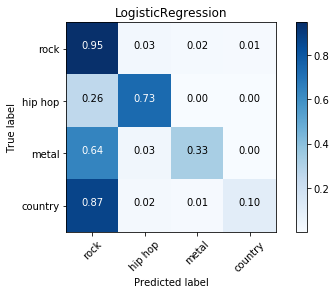

In [0]:
cnf_matrix = confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='LogisticRegression')
score

In [0]:
#Create Naive Bayes Classifier
number = 1 / 548272
model = MultinomialNB(alpha=number)
model.fit(X_train, Y_train)
y_pred = model.fit(X_train, Y_train).predict(X_test)
score = model.score(X_test, Y_test)
cnf_matrix = confusion_matrix(Y_test, y_pred)

In [0]:
# Create a MaxEntropy classifier
import scipy
import nltk.classify
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS
# ['GIS','IIS','CG','BFGS','Powell','LBFGSB','Nelder-Mead','MEGAM','TADM']
print(algorithm)
# MEGAM or TADM are not rec'd for text classification
mec = nltk.classify.MaxentClassifier.train(X_train,Y_train, 'GIS', max_iter=5)


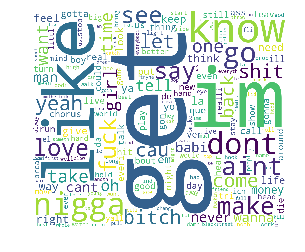

In [0]:
#visualization => wordcloud
def word_cloud(array):
    word_string=[tokenizer(s) for s in array]
    word_string=[' '.join(i) for i in word_string] 
    word_string=' '.join(word_string)
    
    wordcloud = WordCloud(background_color="white",stopwords=sw,width=1000, height=860, margin=2,collocations=False).generate(word_string)

    #wordcloud = WordCloud(font_path = r'D:\Fonts\simkai.ttf').generate(f)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
word_cloud(Xh)

In [0]:
# five_genre=['rock','pop','hip hop','metal','country']
# five_genre=['hip hop','country']
five_genre=['rock','hip hop','metal','country']


cross_table=pd.DataFrame(data=cnf_matrix,    # values
             index=five_genre,    # 1st column as index
             columns=five_genre) 

list_num=[]

for su in range(0,4):
    g=cross_table.iloc[su,:].sum()
    print(g)
    list_num.append(g)

# print(list_num)

for index,j in enumerate(cross_table.columns):
    for i in cross_table[j]:
        i=i/list_num[index]
#         print(list_num[index])
for j in range(4):
    cross_table.iloc[:,j]=cross_table.iloc[:,j]/list_num[j]
cross_table 

6451
2552
1014
949


,rock,hip hop,metal,country
rock,0.978298,0.041928,0.023669,0.009484
hip hop,0.111611,0.715125,0.003945,0.003161
metal,0.134708,0.010580,0.116371,0.000000
country,0.141993,0.003527,0.000986,0.024236


In [0]:
classifier = Pipeline([('features', FeatureUnion([('text', Pipeline([('colext', TextSelector('Text')),
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, stop_words=stop_words,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
#    ('clf', RandomForestClassifier()),
    ])